In [51]:
# 下载数据集
!kaggle competitions download -c house-prices-advanced-regression-techniques

HTTPSConnectionPool(host='storage.googleapis.com', port=443): Max retries exceeded with url: /kaggle-competitions-data/kaggle-v2/5407/868283/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1766077750&Signature=TdVP7k4nKaVMh3qhLwgcN0PvP%2FVt%2BPyOcSOx%2FR4JDwXBkIUJX9PfcQOXKaPfFBDBJQuNBMd%2BlARFnOYn1gb32GrcqQzI%2FoouSD9mo7X%2FMU4UfRlURECN8A0RJrwQ6%2BGD7lfqWiv6ywPuu6iRU%2FIkTbyOTK7WN87gwmfFPsnOQjnZ%2B02XCRWP36PUc4Ct1JarG%2Filg36fPIXMCZKxtEam8FXVDoBBskCZPd7rIbdX0XhMmeT565Wk%2FEWGDwxGmk6sLBFuJprg%2Fvlu1RqReu42JGkfyvniOGKKXJBcxyIBweDSTnNw2sMZHUm1CfvFcwa12%2BMEmesovpotPL%2Fsq%2Fhyfw%3D%3D&response-content-disposition=attachment%3B+filename%3Dhouse-prices-advanced-regression-techniques.zip (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1147)')))


In [52]:
import zipfile
import os
import pandas as pd

In [53]:
# 解压数据
path = "house-prices-advanced-regression-techniques"
if not os.path.exists(path):
    os.makedirs(path)
base_dir = os.path.dirname(path)
fp = zipfile.ZipFile("house-prices-advanced-regression-techniques.zip", 'r')
fp.extractall(path)

In [54]:
# 读取数据
train_data = pd.read_csv(f"{path}/train.csv")
test_data = pd.read_csv(f"{path}/test.csv")
print(train_data.shape)
print(test_data.shape)
# DataFrame.iloc基于整数位置（而非列命来选择数据，使用行号和列号定位）
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [55]:
import torch
import numpy as np
# 数据预处理-连续值
# 1.移除对训练无意义的ID，拼接训练和测试csv数据为一个完整数据集，注意iloc中的-1不包含-1位置（最后一列）1:-1和1:的列数相同
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:, 1:]))
# 2.将所有缺失值替换为相应特征的均值
# 3.归一化（将所有特征放在一个共同的尺度上，将特征重新缩放到零均值和单位方差来标准化数据） x（特征）-μ（均值）/σ（标准差）
#   归一化后方便优化，避免数据尺度差异导致的梯度爆炸或消失等问题、同时因为不确定特征之间的相关性，不能随意分配惩罚给一个特征的系数比其他的特征大
numeric_features_index = all_features.dtypes[all_features.dtypes != 'object'].index # 取出所有数字类型的特征的列index
# lambda可创建一个临时函数，lambda param_{1},...param_{n}: expression
# apply函数用于对当前数据集中的每一个元素应用一个函数，实现批量加工

# 先对数值特征取对数
all_features[numeric_features_index] = all_features[numeric_features_index].apply(lambda x:np.log1p(x))
# 对数特征进行标准化
all_features[numeric_features_index] = all_features[numeric_features_index].apply(lambda x:(x-x.mean()) / (x.std()))
# 在标准化后，所有均值消失，可将缺失值设置为0（标准化的本质是中心化，将分布的均值设置为0）
all_features[numeric_features_index] = all_features[numeric_features_index].fillna(0)

# 数据预处理-离散值：使用独热编码处理
# get_dummies将离散值转换为独热编码表示，对每一列中的每一个离散值，都将其作为新的一列，并使用独热编码（0或1）设置其值为数值，dummy_na可将na（缺失值）也视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
all_features.shape
all_features.dtypes

MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca       int64
SaleCondition_Family       int64
SaleCondition_Normal       int64
SaleCondition_Partial      int64
SaleCondition_nan          int64
Length: 330, dtype: object

In [56]:
# 转换为张量
# 从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练
n_train = train_data.shape[0]
# 从拼接的全部特征中取出测试集部分
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features  = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 对labels进行对数化和标准化
train_data['SalePrice'] = train_data['SalePrice'].apply(lambda x:np.log1p(x))
print(f"log {train_data['SalePrice'][1:2]}")
train_data['SalePrice'] = train_data['SalePrice'].apply(lambda x: (float(x)-np.mean(train_data['SalePrice'])) / np.std(train_data['SalePrice']))
print(f"标准化 {train_data['SalePrice'][1:2]}")
# 取出labels
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)
print(train_labels[1:2])

log 1    12.109016
Name: SalePrice, dtype: float64
标准化 1    0.212763
Name: SalePrice, dtype: float64
tensor([[0.2128]])


In [90]:
from torch import nn
# 基线模型
loss = nn.MSELoss()
in_features = train_features.shape[1]
print(in_features)

class LogRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_features, 1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            return self.net(x)
        return torch.expm1(self.net(x))

def get_net() -> nn.Module:
    """基线模型 返回一个标量输出

    Returns:
        nn.Module: PyTorch Module
    """
    net = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, 1))
    return net

330


In [58]:
from torch.types import Number

def log_rmse(net: nn.Module, features: torch.Tensor, labels: torch.Tensor) -> Number:
    """对数相对误差的均方损失

    Args:
        net (nn.Module): 模型
        features (torch.Tensor): 特征
        labels (torch.Tensor): 标签

    Returns:
        Number: 损失值
    """
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    rmse = torch.sqrt(loss(clipped_preds, labels))
    return rmse.item()

In [ ]:
from d2l import torch as d2l

def train(net: nn.Module, train_features: torch.Tensor, train_labels: torch.Tensor, test_features: torch.Tensor, test_labels: torch.Tensor, num_epochs: int, learning_rate: float, weight_decay: float, batch_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    """模型训练

    Args:
        net (nn.Module): 模型
        train_features (torch.Tensor): 训练集特征值
        train_labels (torch.Tensor): 训练集labels
        test_features (torch.Tensor): 测试集特征值
        test_labels (torch.Tensor): 测试集labels
        num_epochs (int): 迭代次数
        learning_rate (float): 学习率
        weight_decay (float): 权重惩罚系数
        batch_size (int): 批次大小

    Returns:
        tuple[torch.Tensor, torch.Tensor]: 训练损失和测试集损失
    """
    train_loss, test_loss = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size=batch_size)
    
    # Adam优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    for _ in range(num_epochs):
        # net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            l: torch.Tensor = loss(net(X), y)
            l.backward()
            optimizer.step()
        # 使用相对误差衡量损失（如果直接将特征转为对数，使用对数特征进行训练，输出后再转回标量输出会如何？）
        # net.eval()
        train_loss.append(l.mean().detach().numpy())
        if test_labels is not None:
            test_loss.append(loss(net(test_features), test_labels).mean().detach().numpy())
    return train_loss, test_loss

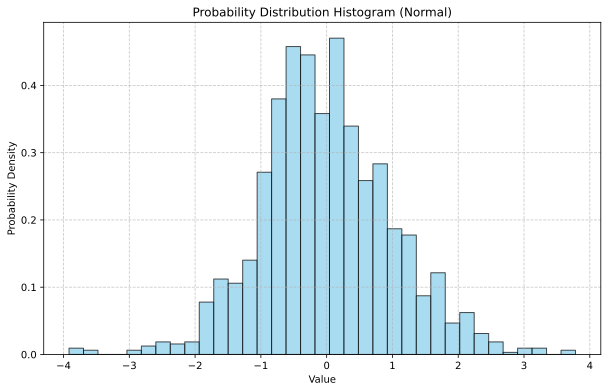

In [66]:
# 绘制labels分布图以及对数化后labels分布图
# 转换为对数之前，SalePrice的分布接近于长尾分布，模型会更加关注高价格，对数之后呈钟形分布，方差更均匀
# 同时对模型的解释性更高，取对数后对模型的预测变为比例变化，对于回归模型而言，特征增加而非房价的固定金额变化，而是房价增加的比例变化
import matplotlib.pyplot as plt
import numpy as np

# 先对房价取对数 改善分布 再进行标准化调整尺度
plt.figure(figsize=(10, 6)) # figsize=(宽度, 高度)
plt.hist(x=train_data['SalePrice'], bins='auto', density=True, alpha=0.7, color="skyblue", edgecolor="black") # density将频数转换成概率密度
plt.title("Probability Distribution Histogram (Normal)")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [61]:
# K折交叉验证
def get_k_fold(k: int, i: int, X: torch.Tensor, y: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """创建K折交叉验证数据集

    Args:
        k (int): 需要的fold数量
        i (int): _description_
        X (torch.Tensor): features
        y (torch.Tensor): labels

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: features测试集、labels测试集、features验证集、labels测试集
    """
    assert k > 1
    fold_size = X.shape[0] // k # 每一个fold的数据集大小
    X_train, y_train = None, None
    for j in range(k):
        # slice用于创建切片对象，与直接使用切片语法[start:stop:step]一样
        # 这里创建了从第k个fold的开始位置和结束位置的切片
        idx = slice(j*fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx] # 每一折的数据集，为features和labels
        if j == i:
            X_valid, y_valid = X_part, y_part # 第K折作为验证集
        elif X_train is None:
            X_train, y_train = X_part, y_part # 添加第一批测试集
        else:
            # 添加测试集features和测试集labels
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k: int, X_train: torch.Tensor, y_train: torch.Tensor, num_epochs: int, learning_rate: float, weight_decay: float, batch_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    """K折交叉验证

    Args:
        k (int): fold数量
        X_train (torch.Tensor): 训练集features
        y_train (torch.Tensor): 训练集labels
        num_epochs (int): 迭代次数
        learning_rate (float): 学习率
        weight_decay (float): L2正则化权重平方和
        batch_size (int): 批量大小

    Returns:
        tuple[torch.Tensor, torch.Tensor]: 训练平均损失、验证平均损失
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold(k, i, X_train, y_train) # 创建第i折fold数据集
        net = LogRegressionModel() # 模型
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i+1}, 训练log rmse{float(train_ls[-1]):f}',
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

tensor([[0.5651]])
tensor([[0.2128]])
折1, 训练log rmse0.050939 验证log rmse0.085641
折2, 训练log rmse0.074101 验证log rmse0.127309
折3, 训练log rmse0.031815 验证log rmse0.112054
折4, 训练log rmse0.038917 验证log rmse0.085152
折5, 训练log rmse0.032113 验证log rmse0.148278
5折验证：平均训练log rmse: 0.045577 平均验证log rmse: 0.111687


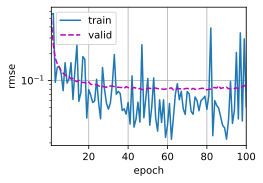

In [91]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.001, 0.001, 64
print(train_features[1:2, 1:2])
print(train_labels[1:2])
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}折验证：平均训练log rmse: {float(train_l):f}',
      f'平均验证log rmse: {float(valid_l):f}')

# 欠拟合：训练误差和验证误差都很大的情况，通常表示模型过于简单，表达能力不足
# 过拟合：过拟合表现在训练误差明显小于验证误差的情况

In [63]:
# K折交叉验证
# python -m pip install -U skorch
# pip install scikit-learn
from skorch import NeuralNetBinaryClassifier, NeuralNetRegressor # 二分类任务、回归任务
from sklearn.model_selection import GridSearchCV, train_test_split
import torch.optim as optimizer

X_train, X_valid, y_train, y_valid = train_test_split(
        train_features,
        train_labels,
        test_size=0.2,
        random_state=42)

# 使用skorch包装模型
model = NeuralNetRegressor(
    module=get_net(),         # 指定模型，继承自nn.Module
    criterion=loss,           # 指定损失函数（回归任务，使用MSE，均方差损失）
    optimizer=optimizer.Adam, # 指定优化器，为torch.optim
    lr=0.01,                  # 学习率
    max_epochs=10,            # 训练轮数（迭代次数）
    verbose=False,            # 是否显示训练过程中的详细信息
    device="cuda"             # 训练设备
)

# 定义要搜索的超参网格
param_grid = {
    'batch_size': [10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 50, 100],
    'lr': [0.001, 0.01, 0.1, 5]
}

# 创建GridSearchCV
grid_search = GridSearchCV(
    estimator=model,                  # estimator object（模型对象，由NeuralNetBinaryClassifier转换而来）
    param_grid=param_grid,            # dict或list of dicts，用于定义超参的搜索空间
    cv=5,                             # 交叉验证的折数或策略（默认为K折交叉验证）
    scoring='neg_mean_squared_error', # 定义模型评估指标
)

# 进行网格搜索
# grid_search.fit(
#     X=X_train, # 训练数据集的特征
#     y=y_train  # 训练数据集的目标（如果是回归任务，只有一个输出的情况，形状需要是一维数组或向量）
# )

# 打印结果
# print("最佳超参数：", grid_search.best_params_)
# print("最佳准确率：", grid_search.best_score_)

训练log rmse: 0.074986


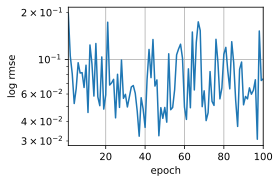

In [87]:
def train_and_pred(train_features: torch.Tensor, valid_features: torch.Tensor, train_labels: torch.Tensor, valid_labels: torch.Tensor, num_epochs: int, lr: float, weight_decay: float, batch_size: int) -> None:
    """_summary_

    Args:
        train_features (torch.Tensor): _description_
        valid_features (torch.Tensor): _description_
        train_labels (torch.Tensor): _description_
        valid_labels (torch.Tensor): _description_
        num_epochs (int): _description_
        lr (float): _description_
        weight_decay (float): _description_
        batch_size (int): _description_
    """
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    # 将网络应用于测试集
    net.eval()
    preds = net(valid_features).detach().numpy()
    # 格式化导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

In [65]:
# !kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"